In [ ]:
import os
import numpy as np
import cv2
from glob import glob
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
! pip install patchify
from patchify import patchify
import tensorflow as tf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Set hyper parameter
hp = {}
hp['image_size'] = 200
hp['num_channels'] = 3
hp['patch_size'] = 25     # Patch Size = Ph * Pw
hp['num_patches'] = (hp['image_size'] ** 2) // (hp['patch_size'] ** 2)  # Number of patches = (H * W) / (Ph * Pw)
hp['flat_patches_shape'] = (hp['num_patches'], hp['patch_size'] * hp['patch_size'] * hp['num_channels'])   #this is going to the input of the VIP
# Transformed Input: (Number of patches, Ph * Pw * C)

In [ ]:
hp['batch_size'] = 32     # Depends on the computational power of the computer/gpu
hp['lr'] = 1e-4
hp['num_epochs'] = 500    # We will use an early stop mechanism
hp['num_classes'] = 5
hp['class_names'] = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [ ]:
hp['num_layers'] = 12
hp['hidden_dim'] = 768
hp['mlp_dim'] = 3072
hp['num_heads'] = 12
hp['dropout_rate'] = 0.1

In [ ]:
def create_dir(path):
  if not os.path.exists(path):
    os.makedirs(path)

In [ ]:
def load_data(path, split=0.1):
  images = shuffle(glob(os.path.join(path, '*', '*.jpg')))
  split_size = int(len(images) * split)
  train_x, valid_x = train_test_split(images, test_size=split_size, random_state=42)
  train_x, test_x = train_test_split(train_x, test_size=split_size, random_state=42)
  return train_x, valid_x, test_x

In [ ]:
def process_image_label(path):
  path = path.decode()     # This funtion is going through the tensorflow, that's why it will be encoded. For that reason, we need to decode it first.
  """ Reading Images """
  image = cv2.imread(path, cv2.IMREAD_COLOR)
  image = cv2.resize(image, (hp['image_size'], hp['image_size']))  # (width, height)
  image = image / 255.0


  """ Preprocessing to patches """ 
  patch_shape = (hp['patch_size'], hp['patch_size'], hp['num_channels'])    # (height, width, channels)
  patches = patchify(image, patch_shape, hp['patch_size'])
  # print(pathces.shape)
  # we need to reshape it to flat_patches_shape

  # patches = np.reshape(patches, (64, 25, 25, 3))
  # for i in range(64):
  #   cv2.imwrite(f'/content/drive/MyDrive/Testing/VIT (Youtube)/files/{i}.png', patches[i]) 

  patches = np.reshape(patches, hp['flat_patches_shape'])
  patches = patches.astype(np.float32)      # need to define data type because we will use it in the tensorflow.

  """ Label """
  # print(path)

  class_name = path.split('/')[-2]
  class_idx = hp['class_names'].index(class_name)
  class_idx = np.array(class_idx, dtype=np.int32) # need to define data type because we will use it in the tensorflow.
  
  return patches, class_idx

In [ ]:
# In the above all the functions we use is outside of Tensorflow. To use those functions in tensorflow I have to use tf.numpy function.

def parse(path):
  patches, labels = tf.numpy_function(process_image_label, [path], [tf.float32, tf.int32])    # (name of the function that will be execute in tensorflow, input, output data type)
  labels = tf.one_hot(labels, hp['num_classes'])

  patches.set_shape(hp['flat_patches_shape'])
  labels.set_shape(hp['num_classes'])

  return patches, labels

In [ ]:
# This is called Input pipeline after converting the numpy data to tensorflow data

def tf_dataset(images, batch=32):
  ds = tf.data.Dataset.from_tensor_slices((images))
  print(ds)
  ds = ds.map(parse).batch(batch).prefetch(8) # automatically create a batch. prefetch -> fetch batches in advance while one processing is running

  return ds

In [ ]:
if __name__ == '__main__':
  """ Seeding """ 
  np.random.seed(42)
  tf.random.set_seed(42)

  """ Directory for storing files """
  FILE_PATH = '/content/drive/MyDrive/Testing/VIT (Youtube)/'
  # create_dir("/content/drive/MyDrive/Testing/VIT (Youtube)/")

  """ Paths """ 
  dataset_path = '/content/drive/MyDrive/Testing/VIT (Youtube)/flower_photos/'
  model_path = os.path.join(FILE_PATH, '/content/drive/MyDrive/Testing/VIT (Youtube)/model.h5')
  csv_path = os.path.join(FILE_PATH, '/content/drive/MyDrive/Testing/VIT (Youtube)/log.csv')

  """ Dataset """
  train_x, valid_x, test_x = load_data(dataset_path)
  print(f'Train: {len(train_x)} - Valid: {len(valid_x)} - Test: {len(test_x)}')

  train_ds = tf_dataset(train_x, batch=hp['batch_size'])
  print(train_ds)
  valid_ds = tf_dataset(valid_x, batch=hp['batch_size'])

  # for x, y in train_ds:
  #   print(x.shape, y.shape)
  #   break

Train: 2936 - Valid: 367 - Test: 367
<TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 1875), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>
<TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>


# VIT

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

class ClassToken(Layer):
  def __init__(self):
    super().__init__()

  def build(self, input_shape):
    w_init = tf.random_normal_initializer()     # initializing the extra learning embedding layer. This is going to be learnable.
    self.w = tf.Variable(
        initial_value = w_init(shape=(1, 1, input_shape[-1]), dtype=tf.float32),  # (batch size, number of layer we want to add, input er last e add korbo)
        trainable = True
    )

  def call(self, inputs):   # execution begin
    batch_size = tf.shape(inputs)[0]     # here patch size is the batch size
    hidden_dim = self.w.shape[-1]        

    cls = tf.broadcast_to(self.w, [batch_size, 1, hidden_dim])    # with the help of this function we're going to properly shape it
    cls = tf.cast(cls, dtype = inputs.dtype)                       
    return cls

In [ ]:
def mlp(x, cf):
  x = Dense(cf['mlp_dim'], activation='gelu')(x)
  x = Dropout(cf['dropout_rate'])(x)
  x = Dense(cf['hidden_dim'])(x)    # Here, output number of feature would be equal to input number of features that is hidden dim.
  x = Dropout(cf['dropout_rate'])(x)

  return x

In [ ]:
def transformer_encoder(x, cf):
  skip_1 = x
  x = LayerNormalization()(x)
  x = MultiHeadAttention(
      num_heads=cf['num_heads'], key_dim=cf['hidden_dim']
  )(x, x)

  x = Add()([x, skip_1])

  skip_2 = x
  x = LayerNormalization()(x)
  x = mlp(x, cf)
  x = Add()([x, skip_2])

  return x

In [ ]:
from typing_extensions import Concatenate
def ViT(cf):
  """ Inputs """
  input_shape = (cf['num_patches'], cf['patch_size'] * cf['patch_size'] * cf['num_channels'])
  inputs = Input(input_shape)   # (None, 256, 3072)
  # print(inputs.shape)

  """ Patch + Position Embedding """
  # we need to pass the input layer to the hidden layer
  patch_embed = Dense(cf['hidden_dim'])(inputs)   #(None, 256, 768)   
  # print(patch_embed.shape)

  positions = tf.range(start=0, limit=cf['num_patches'], delta=1)   # delta is the step
  # print (positions)
  pos_embed = Embedding(input_dim=cf['num_patches'], output_dim=cf['hidden_dim'])(positions)  #(256, 768)
  # print(pos_embed.shape)

  embed = patch_embed + pos_embed   # (None, 256, 768)    This is the size which would remain same in the entire Transformer Network except the MLP.
  # print(embed.shape)


  """ Adding Class Token """
  token = ClassToken()(embed)
  # x = Concatenate(axis=1)([token, embed])
  x = tf.concat(([token, embed]), axis=1)     # (None, 257, 768)
  
  for _ in range(cf['num_layers']):   # Number of transformers we are gonna build
    x = transformer_encoder(x, cf)

  """ Classification Head """
  x = LayerNormalization()(x)
  # print(x.shape)
  x = x[:, 0, :]  
  # print(x.shape)    # (None, 768)
  x = Dense(cf['num_classes'], activation='softmax')(x)

  model = Model(inputs, x)
  return model

In [ ]:
if __name__ == "__main__":
  config = {}
  config['num_layers'] = 12
  config['hidden_dim'] = 768
  config['mlp_dim'] = 3072
  config['num_heads'] = 12
  config['dropout_rate'] = 0.1
  config['num_patches'] = 256
  config['patch_size'] = 32
  config['num_channels'] = 3
  config['num_classes'] = 5

  model = ViT(config)
  model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 3072)]  0           []                               
                                                                                                  
 dense (Dense)                  (None, 256, 768)     2360064     ['input_1[0][0]']                
                                                                                                  
 tf.__operators__.add (TFOpLamb  (None, 256, 768)    0           ['dense[0][0]']                  
 da)                                                                                              
                                                                                                  
 class_token (ClassToken)       (None, 1, 768)       768         ['tf.__operators__.add[0][0]'

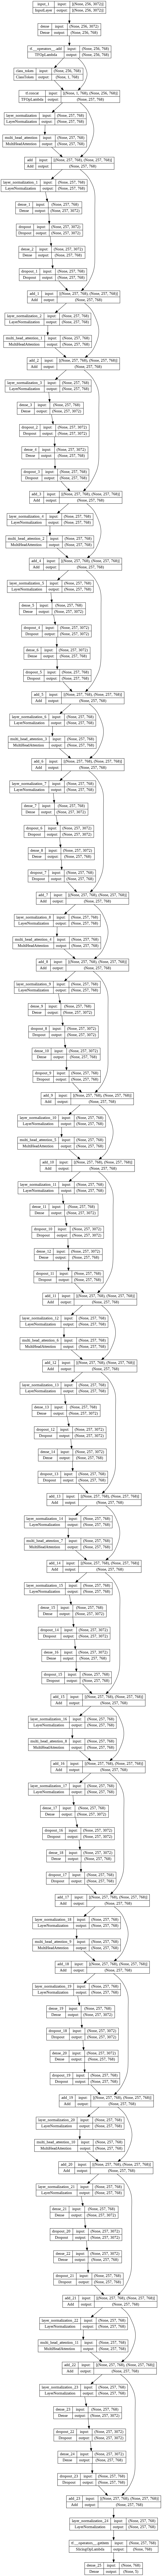

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

# For This Project

In [ ]:
model = ViT(hp)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 64, 1875)]   0           []                               
                                                                                                  
 dense_26 (Dense)               (None, 64, 768)      1440768     ['input_2[0][0]']                
                                                                                                  
 tf.__operators__.add_1 (TFOpLa  (None, 64, 768)     0           ['dense_26[0][0]']               
 mbda)                                                                                            
                                                                                                  
 class_token_1 (ClassToken)     (None, 1, 768)       768         ['tf.__operators__.add_1[0]

In [ ]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(hp['lr'], clipvalue=1.0),
    metrics = ['acc']
)

In [ ]:
#### Callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping

callbacks = [
    ModelCheckpoint(model_path, monitor='val_loss', verbose=1, save_best_only=True),    # Saves the weight file when the validation loss is start to reduce.
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-10),       # Decrease the learning rate when the validation load stops decreasing.
    CSVLogger(csv_path),        # Creates the log file which would contain the training laws, accuracy and everything
    EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=False)   # It monitor the validation loss, for example, continious 50 epochs
    # validation loss does not decrease, it stops the training.
]

In [ ]:
model.fit(
    train_ds,
    epochs = hp['num_epochs'],
    validation_data=valid_ds,
    callbacks=callbacks
)

Epoch 1/500


In [ ]:
""" Seeding """
np.random.seed(42)
tf.random.set_seed(42)

dataset_path = ''
model_path = os.join('files', 'model.h5')
test_ds = tf_dataset(test_x, batch=hp['batch_size'])

# model.load_weights(model_path)

model.evaluate(test_ds)